In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from scipy.signal import butter, filtfilt, spectrogram, iirnotch, lfilter, stft
from scipy.fftpack import fft


import mne
from mne.io import concatenate_raws
from mne.preprocessing import create_ecg_epochs, create_eog_epochs, ICA
plt.rcParams['figure.figsize'] = [15, 8]


In [2]:
# Set channels 
ch_names = ["AFz", "Fz", "Fp1", "Fp2", "AF7", "AF5", "AF3", "AF4", "AF6", "AF8", "F7", 
            "F5", "F3", "F1", "F2", "F4", "F6", "F8", "FT7", "FC5", "FC3", "FC1", "FCz", 
            "FC2", "FC4", "FC6", "FT8", "T7", "C5", "C3", "C1", "Cz", "C2", "C4", "C6", 
            "T8","TP7", "CP5", "CP3", "CP1", "CPz", "CP2", "CP4", "CP6", "TP8", "P7", 
            "P5", "P3", "P1", "Pz", "P2", "P4", "P6", "P8", "PO7", "PO3", "POz", "PO4", 
            "PO8", "O1", "Oz", "O2"]
ch_eogs = ["VEOG", "HEOG"]
ch_names_all = ch_names+ch_eogs

# Sampling Frequency
smp_freq = 1200

In [3]:
# path = (os.path.join(os.path.expanduser('~'),'musec','musec-env','musec', 'experiment_gtec_plux', 'subject', ))
# os.chdir(path)

## Read .csv

In [4]:
csv_file = "s003_gtec_midi_02_066.csv"
X_import = pd.read_csv(csv_file,  names=["Timestamps"]+ch_names+["unknown", "reference"]+ch_eogs)
X_import.head() 

Timestamps          AFz           Fz          Fp1           Fp2  \
0  112.240000 -6695.667969 -7220.564453 -5823.574219 -16080.976562   
1  112.240000 -6687.492188 -7212.437500 -5814.763672 -16073.865234   
2  112.246667 -6682.398438 -7207.509766 -5811.234375 -16072.969727   
3  112.246667 -6678.791016 -7206.216797 -5810.671875 -16073.547852   
4  112.246667 -6676.837891 -7204.714844 -5810.669922 -16071.790039   

           AF7          AF5          AF3          AF4          AF6  ...  \
0 -4484.476562 -2857.824219 -7895.546875 -8752.519531 -7678.359375  ...   
1 -4476.943359 -2850.064453 -7889.345703 -8745.447266 -7672.771484  ...   
2 -4471.789062 -2846.324219 -7886.666016 -8741.949219 -7668.667969  ...   
3 -4470.111328 -2843.369141 -7884.437500 -8740.847656 -7667.220703  ...   
4 -4470.593750 -2841.785156 -7883.859375 -8739.871094 -7666.699219  ...   

           POz          PO4          PO8            O1           Oz  \
0 -7290.781250 -8045.871094 -7249.902344 -10214.982422 -6158.517578   
1 -7285.289062 -8040.185547 -7245.937500 -10210.583984 -6154.535156   
2 -7281.269531 -8037.224609 -7243.894531 -10208.808594 -6151.550781   
3 -7281.546875 -8036.650391 -7245.261719 -10210.828125 -6153.027344   
4 -7282.128906 -8038.953125 -7247.029297 -10211.933594 -6153.863281   

            O2       unknown     reference           VEOG           HEOG  
0 -5415.242188  279961.87500  33167.058594 -149794.562500 -157035.859375  
1 -5411.941406  280453.37500  32675.845703 -149772.343750 -157026.453125  
2 -5410.576172  280914.56250  32213.277344 -149754.390625 -157022.250000  
3 -5410.505859  281339.96875  31786.089844 -149741.562500 -157018.906250  
4 -5410.417969  281747.31250  31380.787109 -149732.296875 -157017.765625  

[5 rows x 67 columns]

## Drop unnecessary

In [5]:
X_after_drop = X_import.drop(columns=["Timestamps", "unknown", "reference"])
X_after_drop.head()

AFz           Fz          Fp1           Fp2          AF7  \
0 -6695.667969 -7220.564453 -5823.574219 -16080.976562 -4484.476562   
1 -6687.492188 -7212.437500 -5814.763672 -16073.865234 -4476.943359   
2 -6682.398438 -7207.509766 -5811.234375 -16072.969727 -4471.789062   
3 -6678.791016 -7206.216797 -5810.671875 -16073.547852 -4470.111328   
4 -6676.837891 -7204.714844 -5810.669922 -16071.790039 -4470.593750   

           AF5          AF3          AF4          AF6           AF8  ...  \
0 -2857.824219 -7895.546875 -8752.519531 -7678.359375 -11950.388672  ...   
1 -2850.064453 -7889.345703 -8745.447266 -7672.771484 -11943.382812  ...   
2 -2846.324219 -7886.666016 -8741.949219 -7668.667969 -11941.175781  ...   
3 -2843.369141 -7884.437500 -8740.847656 -7667.220703 -11939.435547  ...   
4 -2841.785156 -7883.859375 -8739.871094 -7666.699219 -11937.369141  ...   

           PO7          PO3          POz          PO4          PO8  \
0  6023.976562  2896.851562 -7290.781250 -8045.871094 -7249.902344   
1  6026.951172  2902.822266 -7285.289062 -8040.185547 -7245.937500   
2  6026.429688  2907.824219 -7281.269531 -8037.224609 -7243.894531   
3  6022.058594  2909.277344 -7281.546875 -8036.650391 -7245.261719   
4  6020.966797  2909.716797 -7282.128906 -8038.953125 -7247.029297   

             O1           Oz           O2           VEOG           HEOG  
0 -10214.982422 -6158.517578 -5415.242188 -149794.562500 -157035.859375  
1 -10210.583984 -6154.535156 -5411.941406 -149772.343750 -157026.453125  
2 -10208.808594 -6151.550781 -5410.576172 -149754.390625 -157022.250000  
3 -10210.828125 -6153.027344 -5410.505859 -149741.562500 -157018.906250  
4 -10211.933594 -6153.863281 -5410.417969 -149732.296875 -157017.765625  

[5 rows x 64 columns]

## Transform dataframe to array

In [6]:
X_arr = X_after_drop.values
print("Check dimension of data", X_arr.shape)

Check dimension of data (41708, 64)


## Cut first 5 seconds

In [99]:
# Drop 372 points out form the interest of array
X_arr_new = X_arr[0:2]

len(X_arr_new)

2

## Song time (s)

In [8]:
song_time = len(X_arr_new)/1200
song_time

29.75583333333333

## Plot example raw data

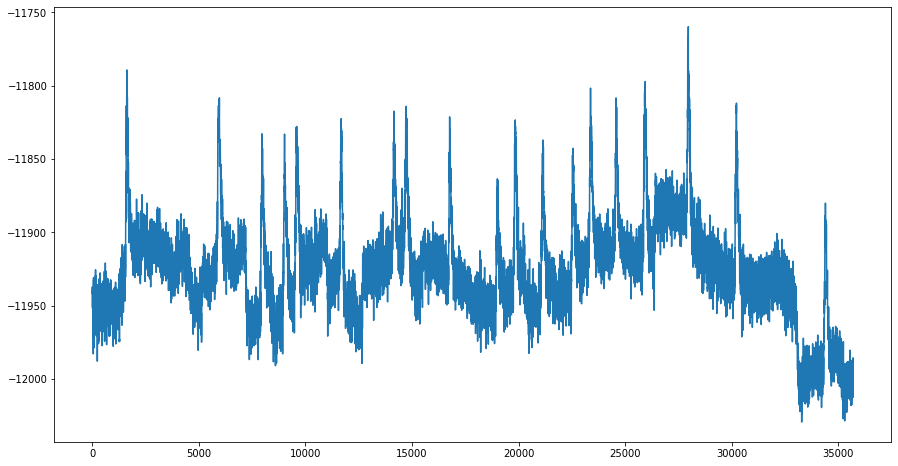

In [9]:
# plot raw data
plt.plot(X_arr_new[:, 9])
plt.show()

## Filtering

In [10]:
# Preprocessing

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def notch_filter(data, f0, fs, Q): # Q = Quality factor
    w0 = f0/(fs/2)
    b, a = iirnotch(w0, Q)
    y = filtfilt(b, a, data)
    return y

def preprocessing(data):
    """Preprocessing time-dimain EEG raw data

    Parameters
    ----------
    data : EEG time-domain raw data 

    Returns
    ----------
    filtered : filtered EEG time-domain raw data 
    """
    filtered = notch_filter(data, 50, smp_freq, 25)
    filtered = butter_highpass_filter(filtered, 1, smp_freq, order=5)
#     filtered = butter_lowpass_filter(filtered, 100, smp_freq)

#     filtered = butter_lowpass_filter(filtered, 30, smp_freq)
    #filtered = butter_bandpass_filter(filtered, 1, 30, smp_freq, 2) # Change from 1-40 Hz to 0.1-40Hz
    print('notch_filter 50 Hz .... banpass 1-40 Hz')
    return filtered

## Preprocessing

In [11]:
X_filtered = preprocessing(X_arr_new)

notch_filter 50 Hz .... banpass 1-40 Hz


## Plot filtered data

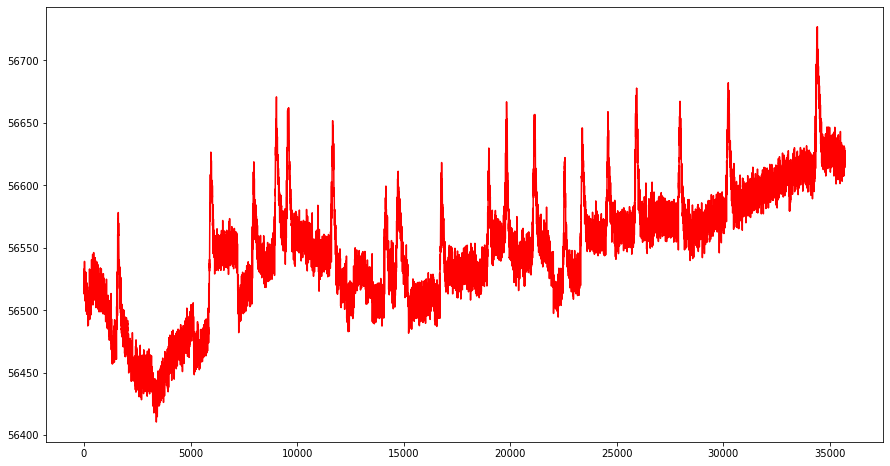

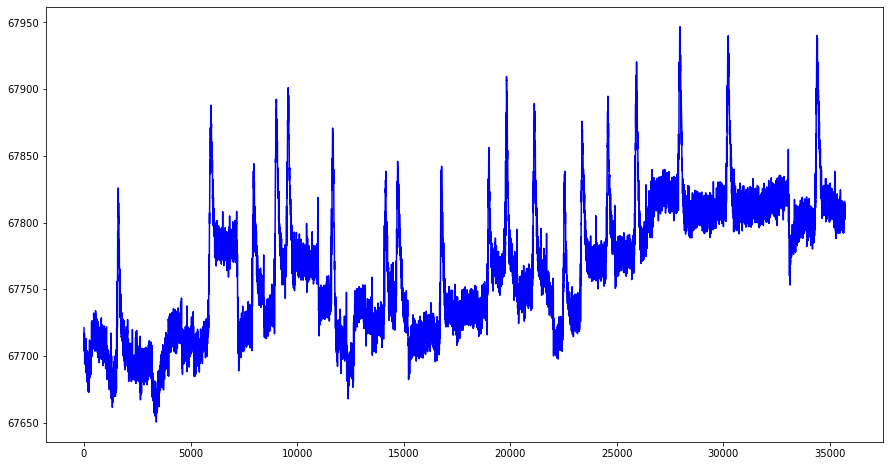

In [12]:
plt.plot(X_filtered[:, 12], "r")
plt.show()
plt.plot(X_filtered[:, 15], "b")
plt.show()

## Transpose data shape

In [13]:
X_swap = X_filtered.T
X_swap

array([[ 47912.82721738,  47913.84661729,  47911.65394246, ...,
         47965.39472207,  47964.77968387,  47964.21385083],
       [ 48056.84602251,  48058.6794816 ,  48056.61202608, ...,
         48141.79407081,  48140.88850464,  48140.73036657],
       [ 49863.03466336,  49867.1896304 ,  49865.88387876, ...,
         49887.66754873,  49885.87164327,  49883.58427378],
       ...,
       [221857.5833824 , 221848.35254899, 221839.99251974, ...,
        222138.47745235, 222142.77862251, 222141.81272537],
       [ 83879.01582425,  83891.43000826,  83902.02374333, ...,
         83985.12813045,  83975.3336045 ,  83964.56451335],
       [ 83372.5493471 ,  83368.12207049,  83363.97067985, ...,
         83453.00081097,  83454.65544793,  83454.91015829]])

## ICA function

In [14]:
def calulate_ICA(arr, save_name=None, threshold=2):
    """
    Parameters
    ----------
    arr : output from collect_data_allphase
    save_name : figure name, keep none if no need to save
    return:
        arr liked array with EOG removal
    """
#     if save_name is not None:
#         for directory in ['ica','eog_score','eog_avg','raw_EEG','corrected_EEG','montage','new_raw']:
#             if not os.path.exists(directory):
#                 os.makedirs(directory)

    # Create a dummy mne.io.RawArray object
#     ch_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eog', 'eog']
    ch_names = ["AFz", "Fz", "Fp1", "Fp2", "AF7", "AF5", "AF3", "AF4", "AF6", "AF8", "F7", 
            "F5", "F3", "F1", "F2", "F4", "F6", "F8", "FT7", "FC5", "FC3", "FC1", "FCz", 
            "FC2", "FC4", "FC6", "FT8", "T7", "C5", "C3", "C1", "Cz", "C2", "C4", "C6", 
            "T8","TP7", "CP5", "CP3", "CP1", "CPz", "CP2", "CP4", "CP6", "TP8", "P7", 
            "P5", "P3", "P1", "Pz", "P2", "P4", "P6", "P8", "PO7", "PO3", "POz", "PO4", 
            "PO8", "O1", "Oz", "O2"]
    ch_eogs = ["VEOG", "HEOG"]
    ch_names_all = ch_names+ch_eogs
    ch_types = ['eeg' for i in range(len(ch_names))] + ['eog', 'eog']
    # Create an info object.
    info = mne.create_info(ch_names=ch_names_all, sfreq=smp_freq, ch_types=ch_types)
    raw = mne.io.RawArray(arr, info)
    raw.set_montage("standard_1020")
    
    ica = ICA(random_state=1)
    ica.fit(raw)

    n_max_eog = 3  # use max 3 components
    eog_epochs = create_eog_epochs(raw)
    eog_epochs.decimate(5).apply_baseline((None, None))

    try:
        eog_inds, scores_eog = ica.find_bads_eog(eog_epochs,threshold=threshold)
        print('Found %d EOG component(s)' % (len(eog_inds),))

        #remove EOG from EEG
        ica.exclude += eog_inds
    except:
        pass
    raw_corrected = raw
    ica.apply(raw_corrected)
    print(ica)

    # #plot
    if save_name is not None:
        ica.plot_sources(raw, show = False).savefig('ica/'+save_name+'_ica.png') 
        try:
            ica.plot_scores(scores_eog, exclude=eog_inds, title='EOG scores',show = False).savefig('eog_score/'+save_name+'_eog_score.png') 
        except:
            pass
        scalings = 'auto'
        ica.plot_sources(eog_epochs.average(), title='EOG average',show = False).savefig('eog_avg/'+save_name+'_eog_avg.png')
        raw.plot(show = False,scalings=scalings).savefig('raw_EEG/'+save_name+'_raw_EEG.png')
        raw_corrected.plot(show = False,scalings=scalings).savefig('corrected_EEG/'+save_name+'_corrected_EEG.png')
        ica.plot_components(inst=raw, show = False)[0].savefig('montage/'+save_name+'_montage.png')
        print('======================================')
        print(raw_corrected.get_data().shape)
        raw_corrected.save('new_raw/'+save_name+'_raw.fif', overwrite=True)
    return raw_corrected

## ICA

Creating RawArray with float64 data, n_channels=64, n_times=35707
    Range : 0 ... 35706 =      0.000 ...    29.755 secs
Ready.
DigMontage is a superset of info. 32 in DigMontage will be ignored. The ignored channels are: {'T6', 'TP9', 'PO1', 'PO2', 'T3', 'PO6', 'P9', 'FT10', 'T4', 'M1', 'AF1', 'F10', 'M2', 'T10', 'O10', 'PO5', 'AF9', 'T5', 'Iz', 'T9', 'A2', 'PO9', 'TP10', 'PO10', 'Fpz', 'A1', 'AF10', 'FT9', 'P10', 'AF2', 'O9', 'F9'}
Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 26.6s.
EOG channel index for this subject is: [62 63]
Filtering the data to remove DC offset to help distinguish blinks from saccades


/home/soravitt/musec/musec-env/lib/python3.6/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)

Now detecting blinks and generating corresponding events
Found 25 significant peaks
Number of EOG events detected : 25
25 matching events found
No baseline correction applied
Not setting metadata
Loading data for 25 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
Found 8 EOG component(s)
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 35707 samples, 62 components, channels used: "ee

<ipython-input-14-66096f79487d>:36: RuntimeWarning: The measurement information indicates a low-pass frequency of 600 Hz. The decim=5 parameter will result in a sampling frequency of 240 Hz, which can cause aliasing artifacts.
  eog_epochs.decimate(5).apply_baseline((None, None))


(64, 35707)
Overwriting existing file.
Writing /home/soravitt/musec/musec-env/musec/new_raw/s003_gtec_midi_01_093_raw.fif
Closing /home/soravitt/musec/musec-env/musec/new_raw/s003_gtec_midi_01_093_raw.fif [done]


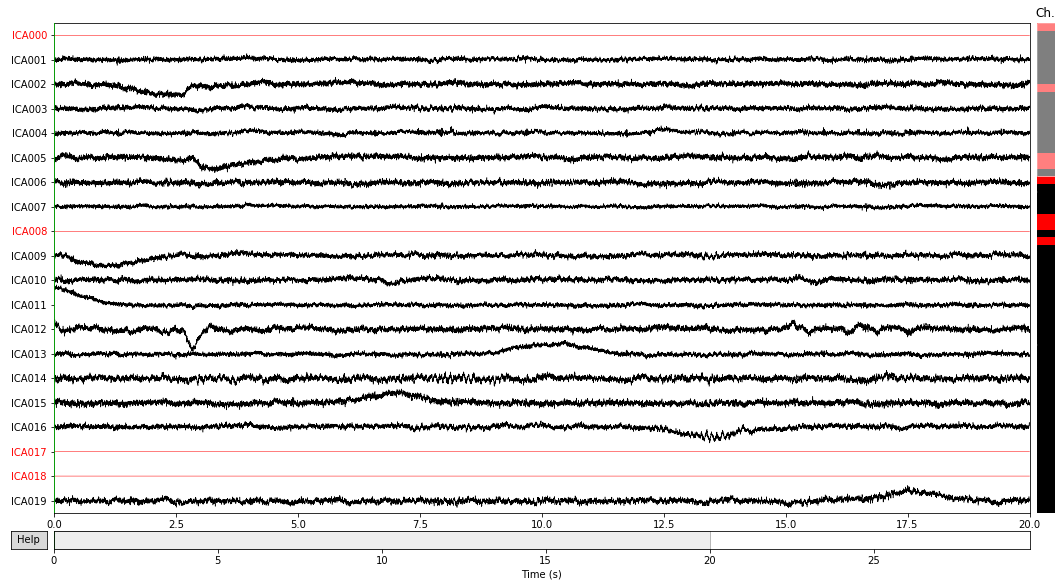

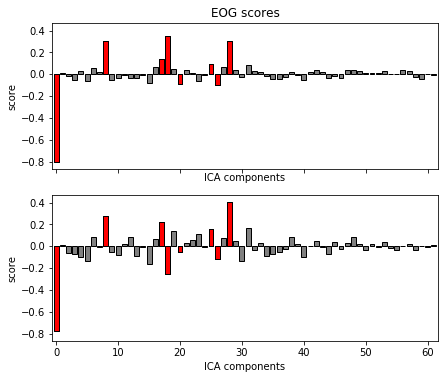

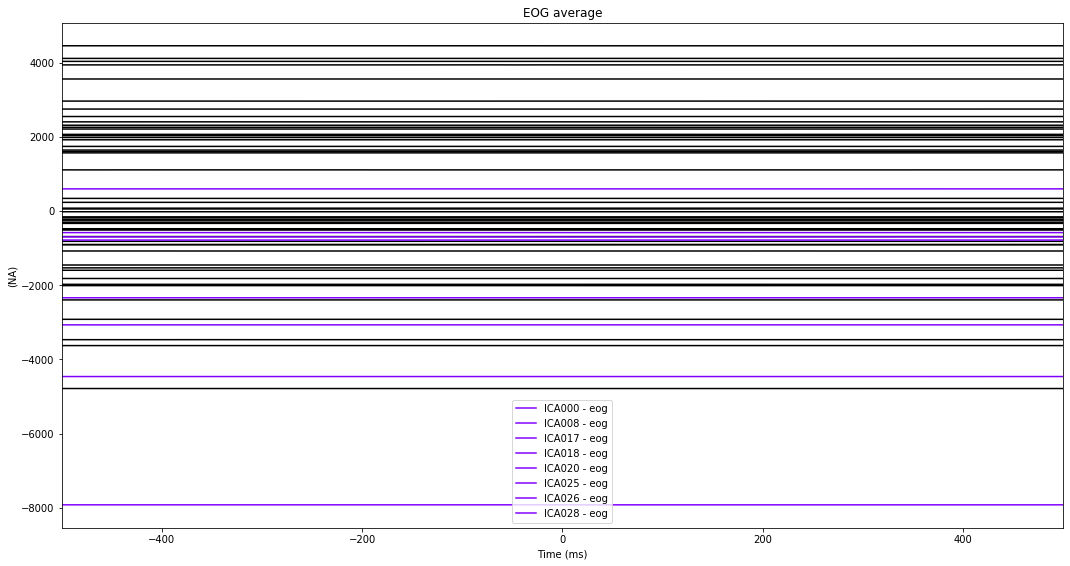

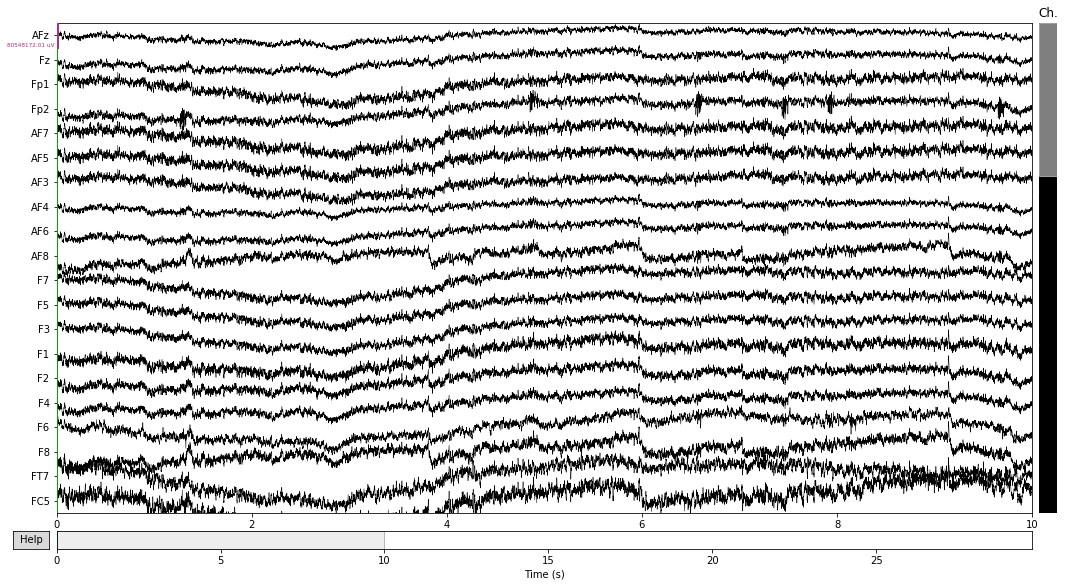

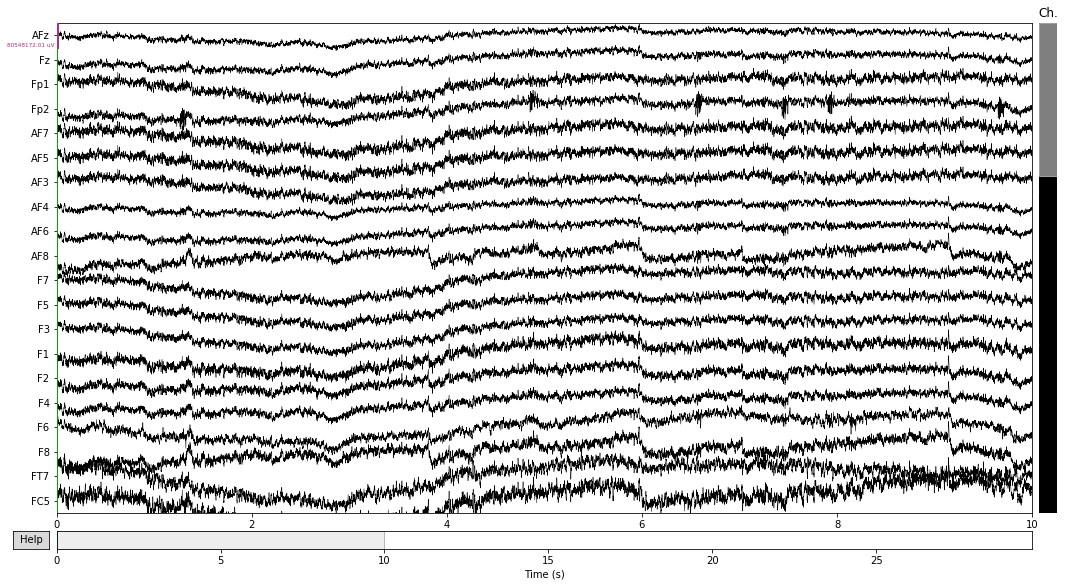

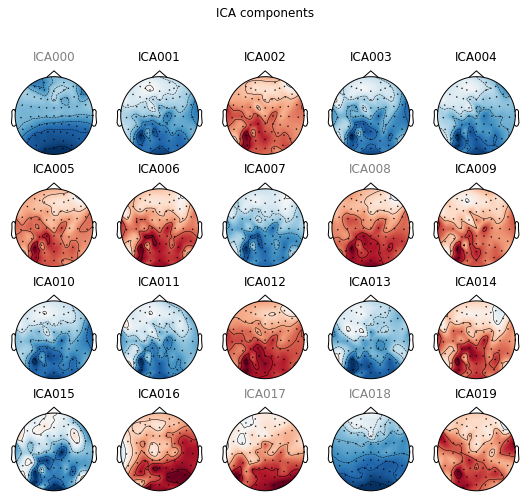

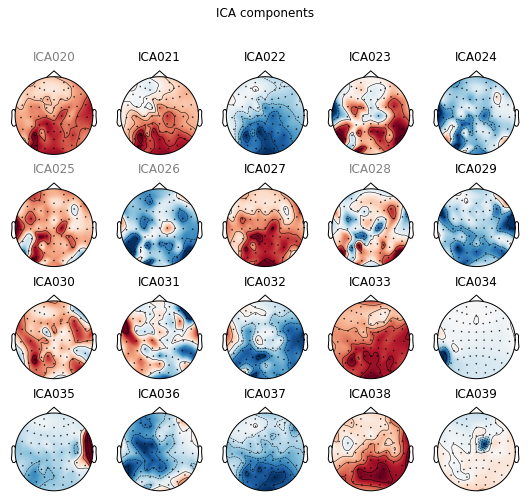

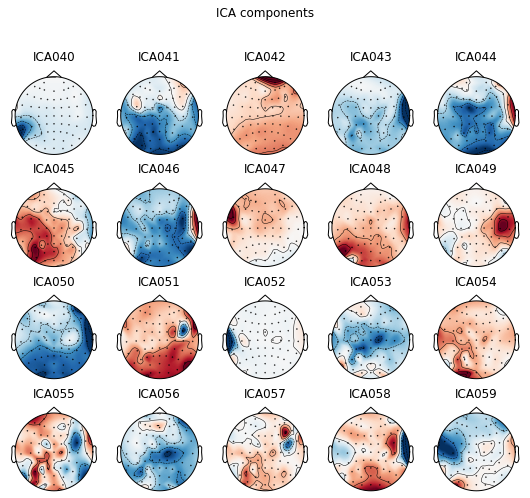

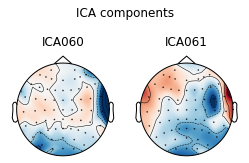

In [15]:
X_eog_removal = calulate_ICA(X_swap, save_name="s003_gtec_midi_01_093", threshold=2)

## Plot data after ICA

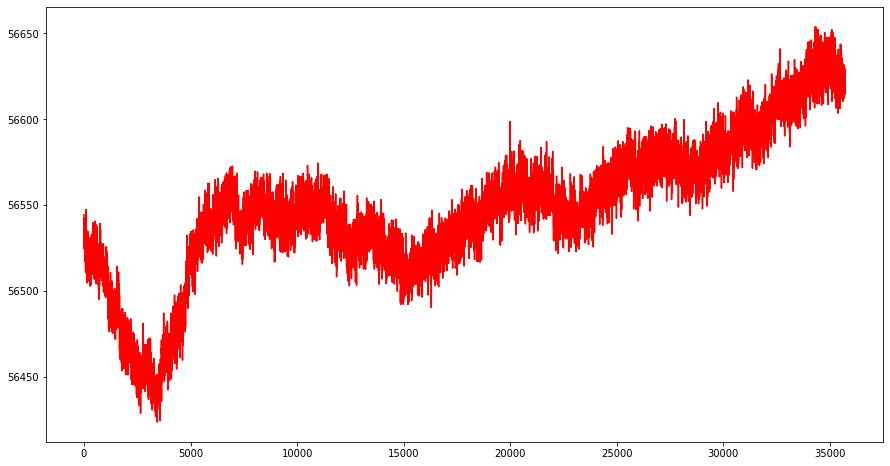

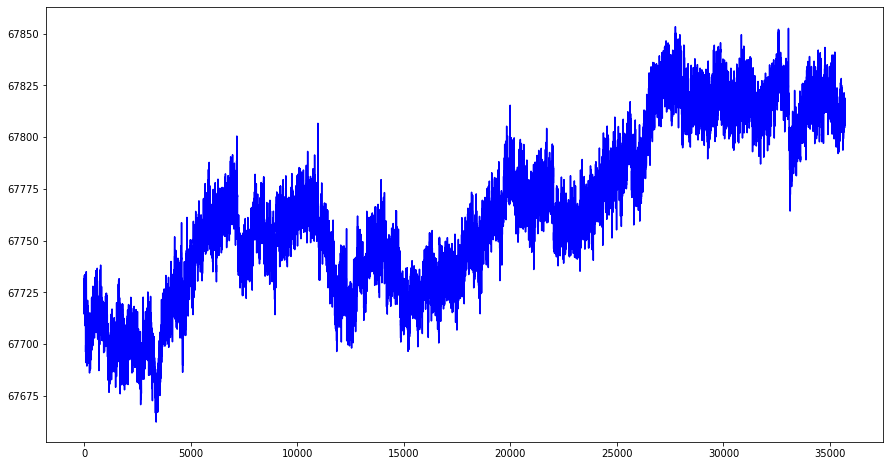

In [16]:
X_correct = X_eog_removal[:][0]
plt.plot(X_correct[12], 'r')
plt.show()
plt.plot(X_correct[15], 'b')
plt.show()

In [17]:
X_eog_removal

<RawArray  |  None, n_channels x n_times : 64 x 35707 (29.8 sec), ~17.6 MB, data loaded>

[[0 0 1]]
1 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 1 events and 35696 original time points ...
0 bad epochs dropped
Loading data for 1 events and 35696 original time points ...
Loading data for 1 events and 35696 original time points ...


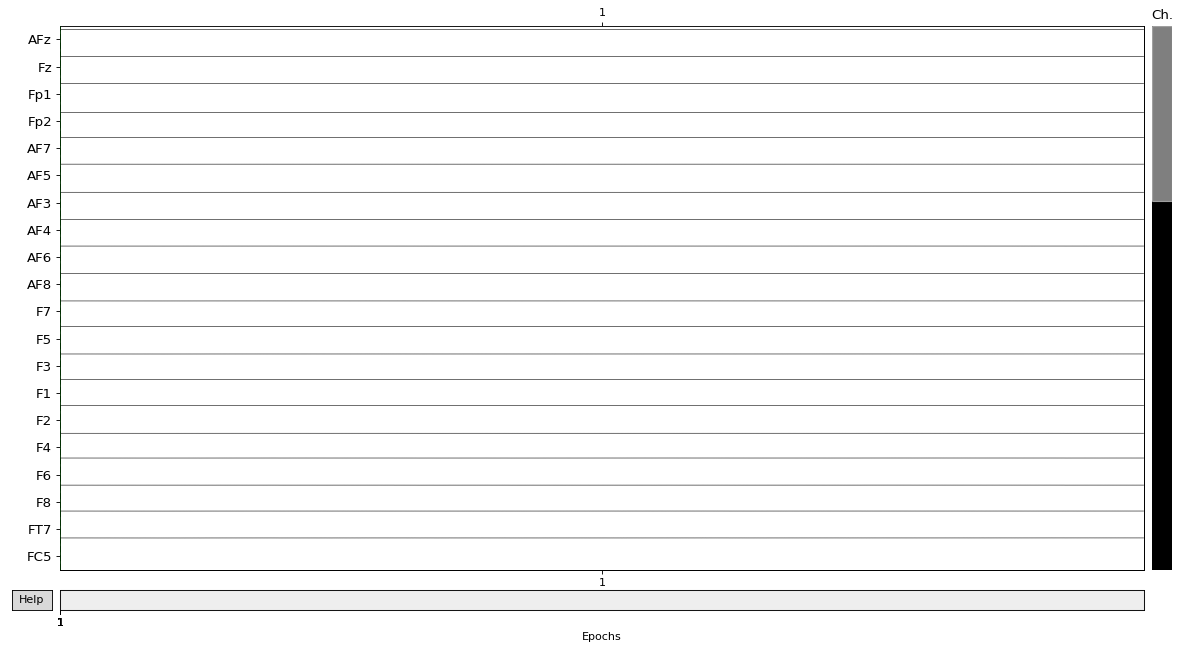

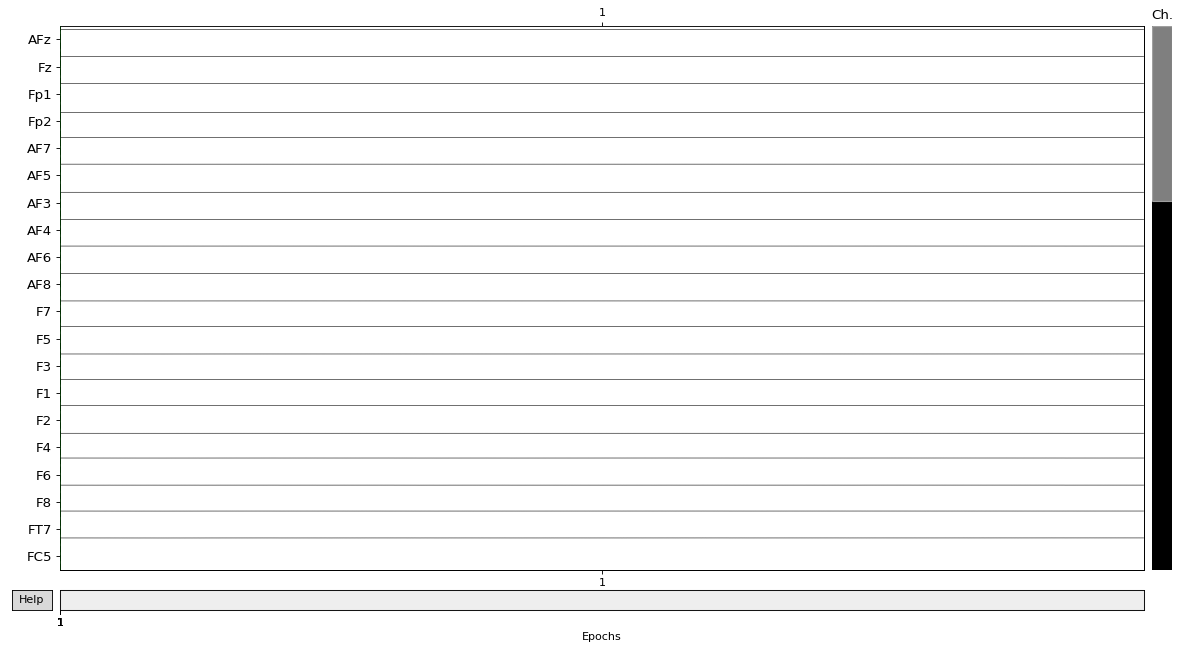

In [18]:
# The events are spaced evenly every 1 second.
duration = song_time
event_id = 1
# create a fixed size events array
# start=0 and stop=None by default
events = mne.make_fixed_length_events(X_eog_removal, event_id, duration=duration)
print(events)

# for fixed size events no start time before and after event
tmin = 0
tmax = song_time - 0.01 # inclusive tmax, 1 second epochs

# create :class:`Epochs <mne.Epochs>` object
epochs = mne.Epochs(X_eog_removal, events=events, event_id=event_id, tmin=tmin,
                    tmax=tmax, baseline=None, verbose=True)
epochs.plot(scalings='auto', block=True)

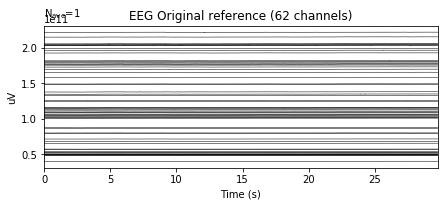

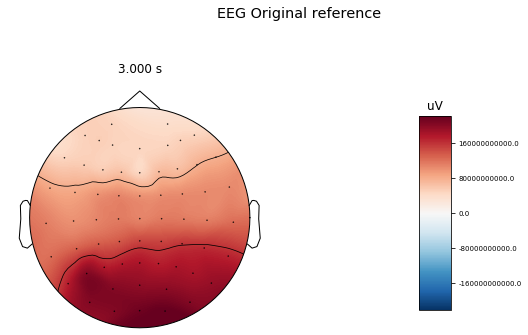

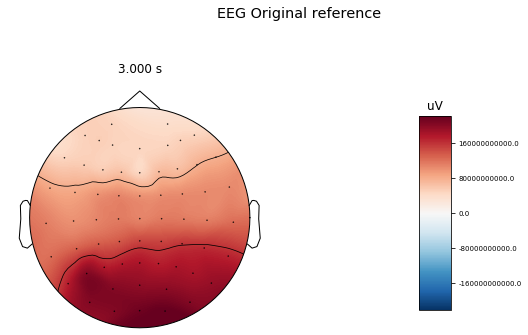

In [19]:
title = 'EEG Original reference'
evoked_no_ref = epochs.average()
evoked_no_ref.plot(titles=dict(eeg=title), time_unit='s')
evoked_no_ref.plot_topomap(times=[3], size=3, title=title, time_unit='s')

## MNE for create CAR

In [20]:
X_eog_removal.del_proj()
raw_car, _ = mne.set_eeg_reference(X_eog_removal, 'average', projection=True) # CAR success
# The events are spaced evenly every 1 second.
duration = song_time
event_id = 1
# create a fixed size events array
# start=0 and stop=None by default
events_car = mne.make_fixed_length_events(raw_car, event_id, duration=duration)
print(events)

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
[[0 0 1]]


1 matching events found
No baseline correction applied
Not setting metadata
Created an SSP operator (subspace dimension = 1)
1 projection items activated


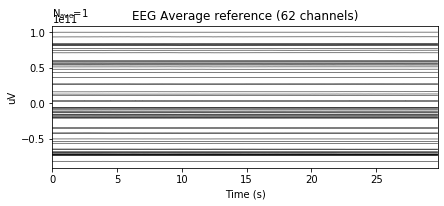

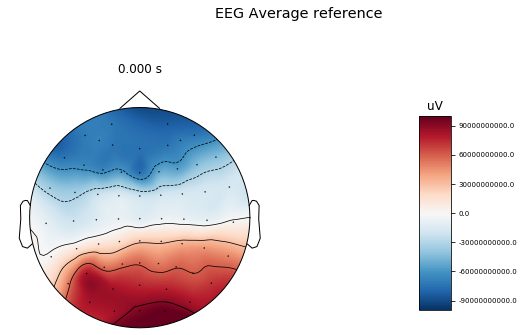

Loading data for 1 events and 35696 original time points ...
0 bad epochs dropped


<ipython-input-21-35fb94098504>:12: DeprecationWarning: spatial_colors defaults to False in 0.19 but will change to True in 0.20. Set it explicitly to avoid this warning.
  epochs_car.plot_psd(fmin=1., fmax=40.)
<ipython-input-21-35fb94098504>:12: DeprecationWarning: average defaults to True in 0.19 but will change to False in 0.20. Set it explicitly to avoid this warning.
  epochs_car.plot_psd(fmin=1., fmax=40.)


    Using multitaper spectrum estimation with 7 DPSS windows


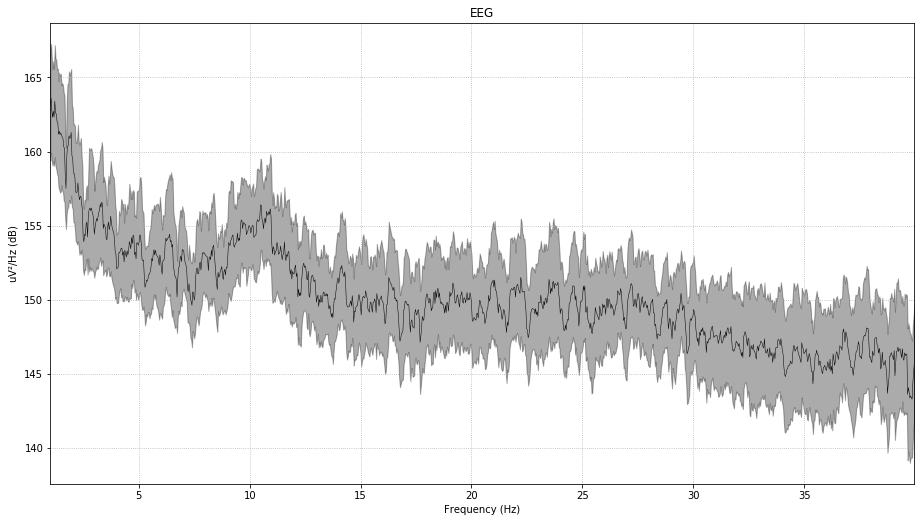

Loading data for 1 events and 35696 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows


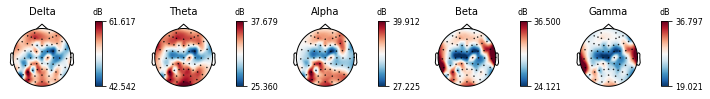

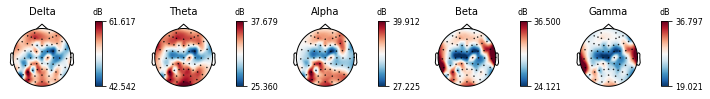

In [21]:
# for fixed size events no start time before and after event
tmin = 0.
tmax = song_time - 0.01 # inclusive tmax, 1 second epochs

# create :class:`Epochs <mne.Epochs>` object
epochs_car = mne.Epochs(raw_car, events=events_car, event_id=event_id, tmin=tmin,
                    tmax=tmax, baseline=None, verbose=True)
epochs_car_avg = epochs_car.average()
title = 'EEG Average reference'
epochs_car_avg.plot(titles=dict(eeg=title), time_unit='s')
epochs_car_avg.plot_topomap(times=[0], size=3., title=title, time_unit='s')
epochs_car.plot_psd(fmin=1., fmax=40.)
epochs_car.plot_psd_topomap(ch_type='eeg', normalize=False)

## Filter 2nd time

Setting up band-pass filter from 5 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 5.00, 30.00 Hz: -6.02, -6.02 dB



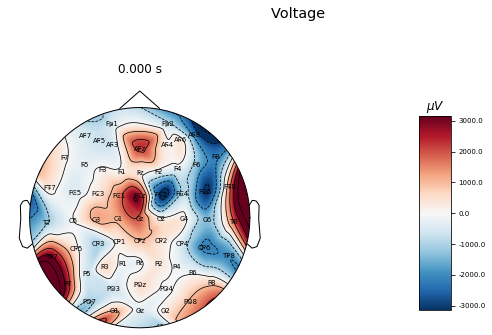

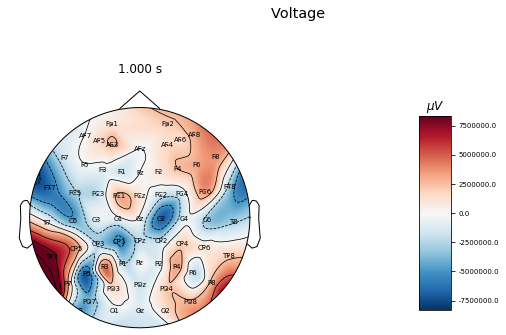

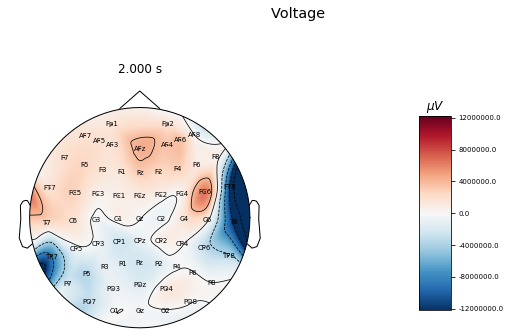

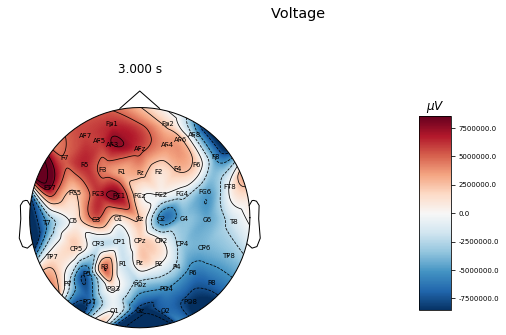

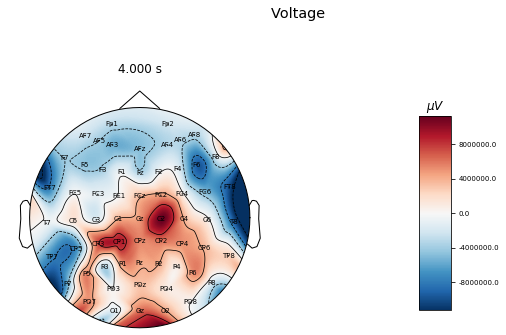

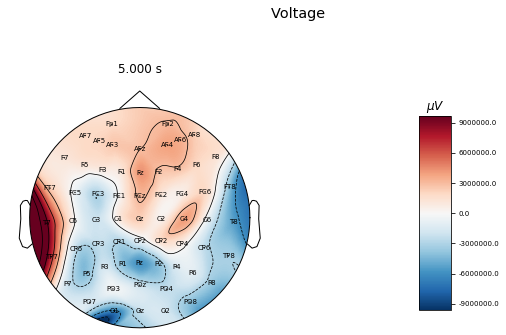

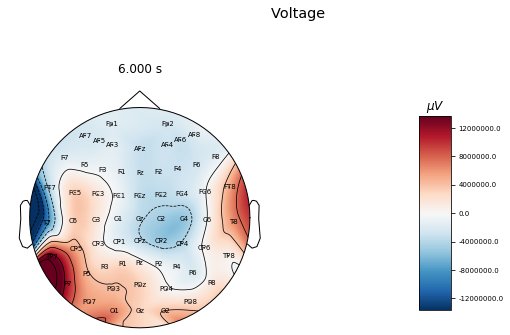

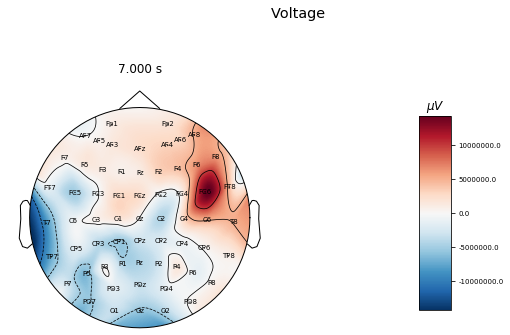

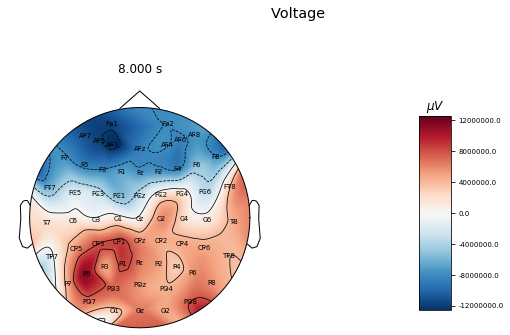

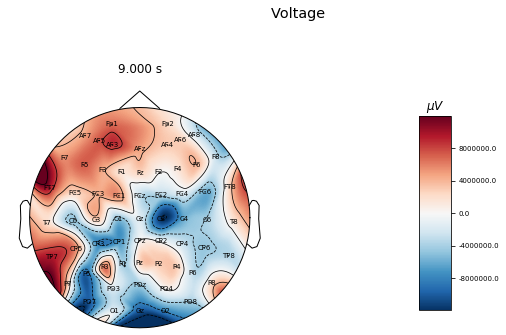

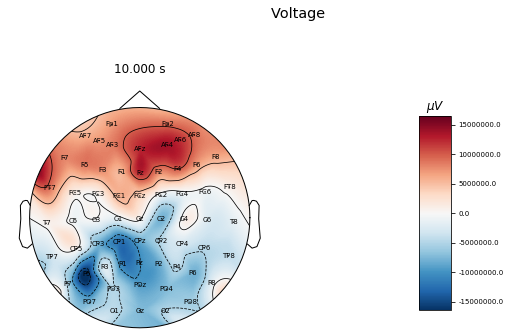

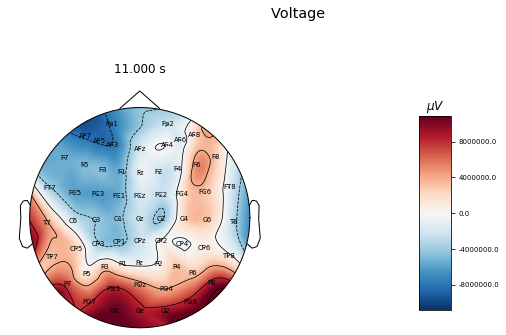

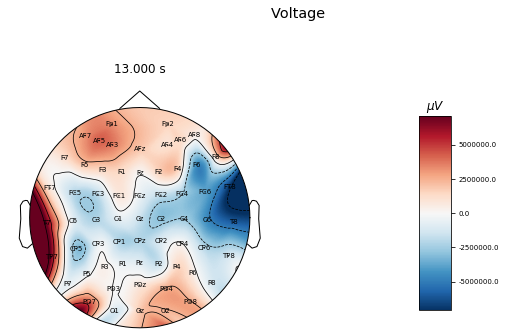

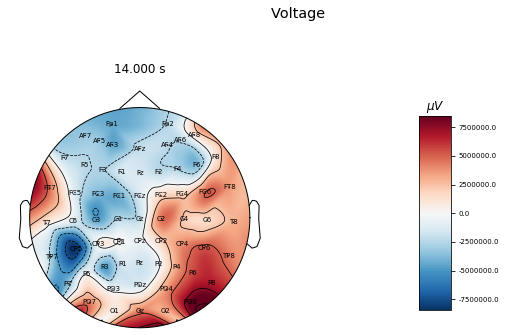

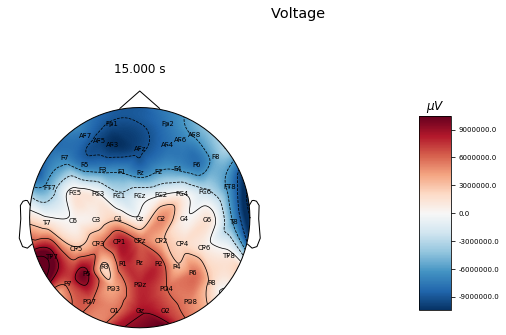

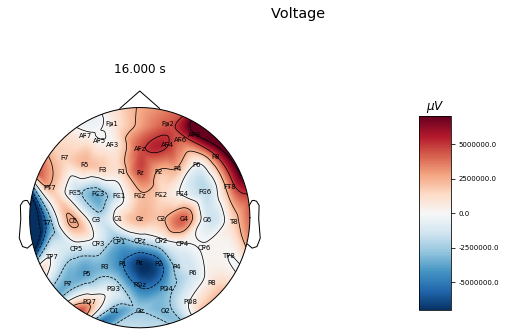

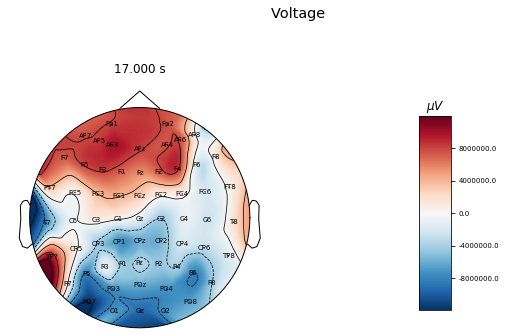

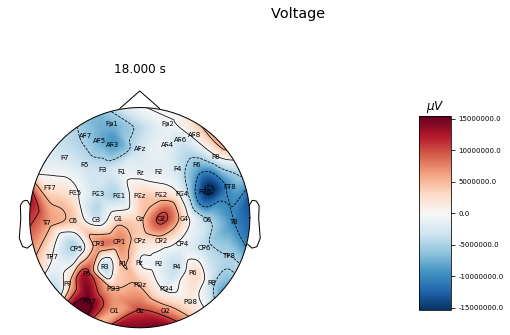

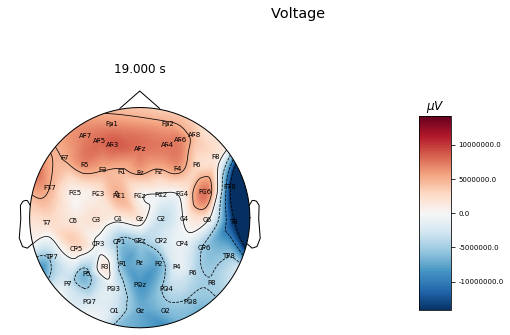

In [22]:
# Perform bandpass-filter for alphaband Theta(4-7 Hz), Alpha(8-15 Hz), Beta(8-31), Gamma (>32Hz), Mu (8-12 Hz.)

epochs_car_avg.filter(l_freq=5, h_freq=30., method="iir")
time_difine = np.arange(0, 20, 1)
for t in time_difine:
    epochs_car_avg.plot_topomap([t], ch_type='eeg', contours=6, show_names=True, size=(3), 
                                res=256, units="$\mu V$", time_unit='s', 
                                cmap="RdBu_r", title="Voltage", scalings=dict(eeg=1e6))
    
# epochs_car_avg.plot_topomap(time_difine, ch_type='eeg', contours=6, show_names=True, size=(3), 
#                             res=256, units="$\mu V$", time_unit='ms', 
#                             cmap="RdBu_r", title="Voltage", scalings=dict(eeg=1e6))

In [23]:
# epochs_car_avg.plot_topo(background_color='k')

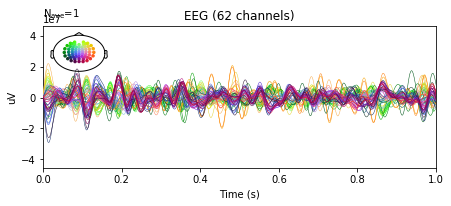

In [24]:
epochs_car_avg.plot(spatial_colors = True, xlim=[0,1])


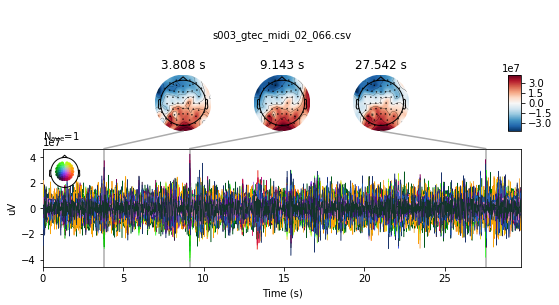

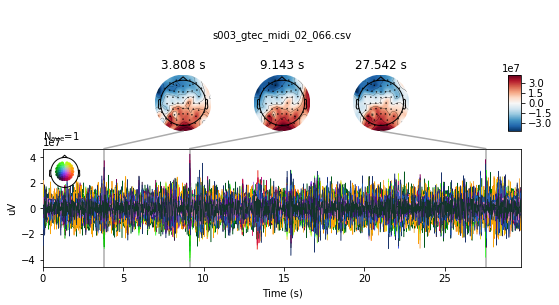

In [25]:
epochs_car_avg.plot_joint(title=csv_file)

## CAR data

In [26]:
epochs_car_avg_new = epochs_car_avg.to_data_frame().values.T


Converting "time" to "<class 'numpy.int64'>"...


In [27]:
epochs_car_avg_new

array([[ 2.21191074e+03,  1.38178837e+06,  2.74375241e+06, ...,
        -1.03089442e+06, -5.22415015e+05, -4.50868879e+03],
       [ 2.51125085e+02,  1.33470288e+06,  2.65030871e+06, ...,
        -1.22480903e+06, -6.20222739e+05, -4.61273328e+03],
       [-4.53958674e+02,  5.56472377e+05,  1.11004280e+06, ...,
        -2.56368184e+06, -1.29372270e+06, -3.63956698e+03],
       ...,
       [ 1.08937290e+03, -7.32095210e+05, -1.45556928e+06, ...,
         2.79580764e+06,  1.40985580e+06,  5.57580661e+03],
       [-3.47338886e+02, -9.28836326e+05, -1.84607923e+06, ...,
         3.00095198e+06,  1.51359984e+06,  7.61842219e+03],
       [ 3.33404106e+02, -2.15983093e+05, -4.26988701e+05, ...,
         3.13891529e+06,  1.58290060e+06,  7.86100220e+03]])

# Create an info object again

In [28]:
ch_types = ['eeg' for i in range(len(ch_names))] 
info = mne.create_info(ch_names=ch_names, sfreq=smp_freq, ch_types=ch_types)
raw = mne.io.RawArray(epochs_car_avg_new, info)
raw.set_montage("standard_1020")

Creating RawArray with float64 data, n_channels=62, n_times=35696
    Range : 0 ... 35695 =      0.000 ...    29.746 secs
Ready.
DigMontage is a superset of info. 32 in DigMontage will be ignored. The ignored channels are: {'T6', 'TP9', 'PO1', 'PO2', 'T3', 'PO6', 'P9', 'FT10', 'T4', 'M1', 'AF1', 'F10', 'M2', 'T10', 'O10', 'PO5', 'AF9', 'T5', 'Iz', 'T9', 'A2', 'PO9', 'TP10', 'PO10', 'Fpz', 'A1', 'AF10', 'FT9', 'P10', 'AF2', 'O9', 'F9'}


<RawArray  |  None, n_channels x n_times : 62 x 35696 (29.7 sec), ~17.1 MB, data loaded>

In [29]:
# for i in range(len(raw[:][0][0])):
#     a = raw[:][0][i:1200]
    
#     print (a)

[[0 0 1]]
1 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 1 events and 34496 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-30-274e7c37c87d>:19: DeprecationWarning: spatial_colors defaults to False in 0.19 but will change to True in 0.20. Set it explicitly to avoid this warning.
  epochs_car.plot_psd(fmin=1., fmax=40.)
<ipython-input-30-274e7c37c87d>:19: DeprecationWarning: average defaults to True in 0.19 but will change to False in 0.20. Set it explicitly to avoid this warning.
  epochs_car.plot_psd(fmin=1., fmax=40.)


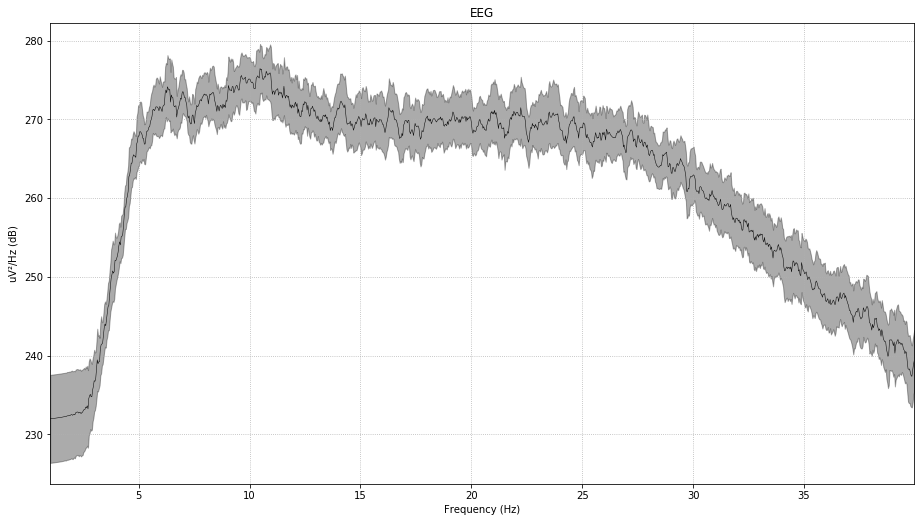

Loading data for 1 events and 34496 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows


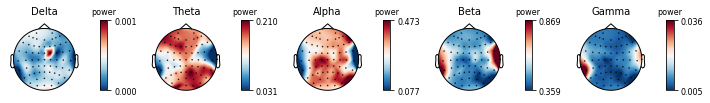

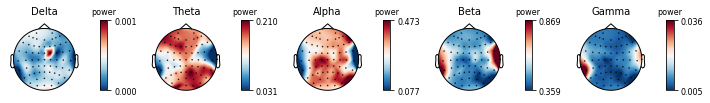

In [30]:
duration = song_time - 0.01
event_id = 1
# create a fixed size events array
# start=0 and stop=None by default
events_car = mne.make_fixed_length_events(raw, event_id, duration=duration)
print(events)

# for fixed size events no start time before and after event
tmin = 1.
tmax = song_time - 0.01 # inclusive tmax, 1 second epochs

# create :class:`Epochs <mne.Epochs>` object
epochs_car = mne.Epochs(raw, events=events_car, event_id=event_id, tmin=tmin,
                    tmax=tmax, baseline=None, verbose=True)
# epochs_car_avg = epochs_car.average()
title = 'EEG Average reference'
# epochs_car.plot(titles=dict(eeg=title), time_unit='s')
# epochs_car.plot_topomap(times=[0], size=3., title=title, time_unit='s')
epochs_car.plot_psd(fmin=1., fmax=40.)
epochs_car.plot_psd_topomap(ch_type='eeg', normalize=True)

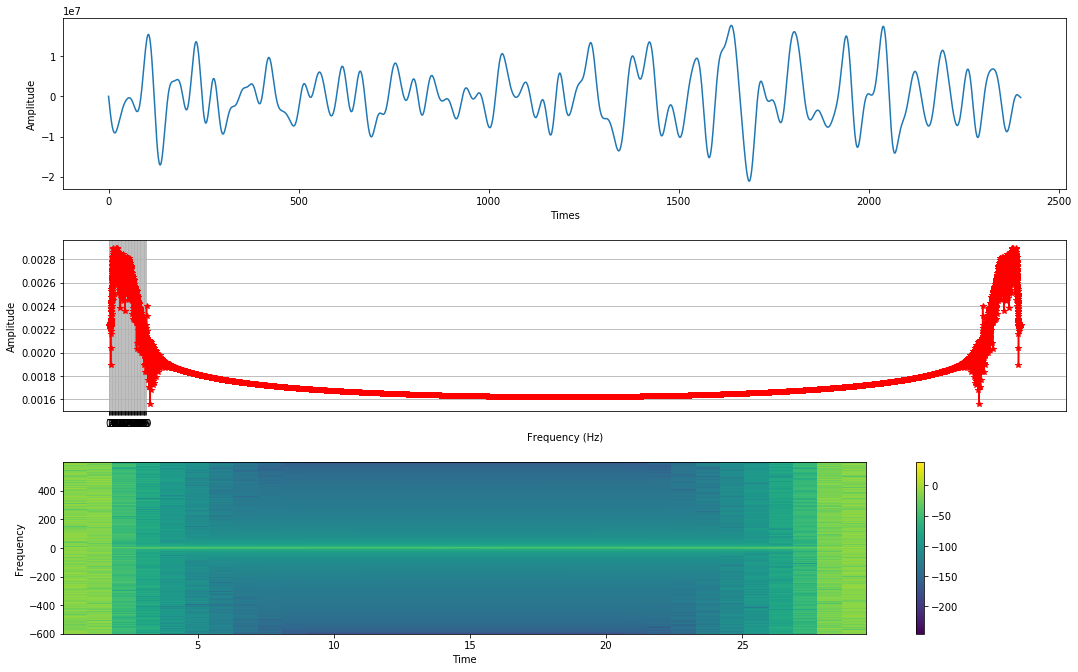

In [69]:
#Plot time series

N = len(epochs_car_avg_new[0])
T = 1.0 / 1200.0
x = np.linspace(0.0, N*T, N) #len x = 573 and N = Number of sample points X
# y = Dat2[:,Time_at] #Selected Bin = Time_at, Row is Time at x-axis




# #Band pass
# lowcut = 1
# highcut = 3
# cutoff = 0.7
# y_Bandpass = butter_bandpass_filter(y, lowcut, highcut, fs=10, order=5)

        

#FFT
y_FFT = fft(epochs_car_avg_new[60])
y_FFT_db = 10*np.log10(y_FFT)
#y_FFT = np.abs(y_FFT)
x_FFT = np.linspace(0.0, 1.0/T, N) #frequency 0-5 

#Plot 
plt.figure(figsize=(15,15))

#Plot time series
plt.subplot(5,1,1)
plt.plot(epochs_car_avg_new[60][:2400])
plt.xlabel('Times')
plt.ylabel('Amplitude')

#Plot FFT
plt.subplot(5,1,2)
plt.xticks(np.arange(0, 50, step=1))
plt.plot(x_FFT, 1.0/N * np.abs(y_FFT_db[0:N]),'r-*')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid()


#Spectogram
plt.subplot(5,1,3)
valueSTFT = plt.specgram(y_FFT_db, NFFT = 1200, Fs = 1200) #noverlap was NFFT-1
plt.colorbar()
# plt.title('Distance' + str(Time_at).zfill(2) + '-Band' + str(lowcut) + '-' + str(highcut))
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)

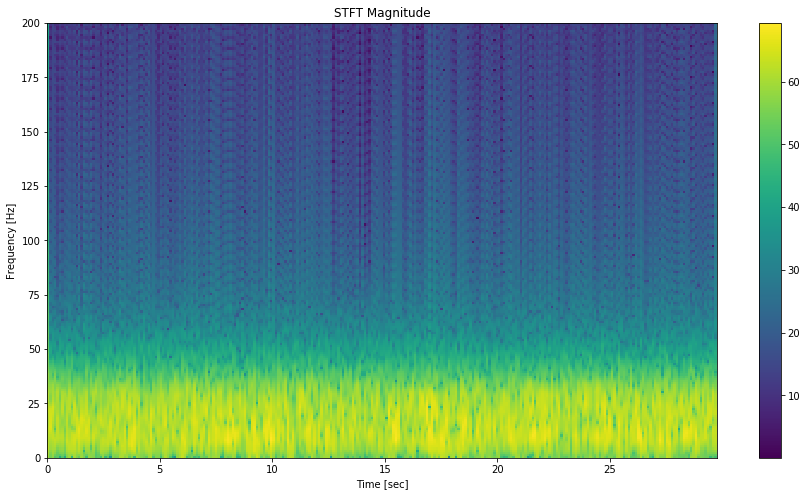

In [68]:
f, t, Zxx = stft(epochs_car_avg_new[15], fs=1200, nfft=1200)
plt.pcolormesh(t, f, np.abs(10*np.log10(Zxx)))
plt.colorbar()
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0,200)
plt.show()